# Figure 1 
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature

Data locations

In [2]:
loc_cmip6_hist_country = "../Data/CMIP6/CountryTemp/Historical/"
loc_cmip6_histnat_country = "../Data/CMIP6/CountryTemp/HistoricalNat/"
loc_cesm_hist_country = "../Data/CESM1-LE/CountryTemp/Historical/"
loc_cesm_histnat_country = "../Data/CESM1-LE/CountryTemp/HistoricalNat/"
loc_cmip6_hist_gmst = "../Data/CMIP6/GMST/Historical/"
loc_cmip6_histnat_gmst = "../Data/CMIP6/GMST/HistoricalNat/"
loc_cesm_hist_gmst = "../Data/CESM1-LE/GMST/Historical/"
loc_cesm_histnat_gmst = "../Data/CESM1-LE/GMST/HistoricalNat/"
loc_shp = "../Data/CountryShapefile/"
loc_pattern = "../Data/PatternScaling/"
loc_gmst_fair = "../Data/FAIR/GMST/"
loc_tdiff_global = "../Data/FAIR/TempDifference/Historical/"
loc_tdiff_countries = "../Data/FAIR/TempDifference/Country-Attributed/"
loc_damages_country = "../Data/Damages/Country-Attributed/"
loc_damages_hist = "../Data/Damages/Historical/"
loc_damagefunc = "../Data/DamageFunction/"
loc_panel = "../Data/Panel/"

Shapefile

In [3]:
shp = gp.read_file(loc_shp)
iso_shp = shp.ISO3.values

Emissions accounting

In [4]:
accounting = "territorial"

Helper function for country plotting

In [5]:
def add_country_geometries(a,input_vals,iso_vals,iso_plot,shapefile,shapefile_iso_name,cbar):

    for i in iso_plot:
        if i in iso_vals:
            val = input_vals.loc[i].values
            if (~np.isnan(val)):
                a.add_geometries(shapefile.loc[shapefile[shapefile_iso_name].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=cbar.to_rgba(val),edgecolor="black",linewidth=0.3)
            else:
                a.add_geometries(shapefile.loc[shapefile[shapefile_iso_name].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.3)
        else:
            a.add_geometries(shapefile.loc[shapefile[shapefile_iso_name].values==i,"geometry"],ccrs.PlateCarree(),
                              facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.3)

#### Analysis

Read GMST and country-level temperature change from the climate model ensembles

In [6]:
models_cmip6 = ["ACCESS-CM2","ACCESS-ESM1-5","BCC-CSM2-MR","CanESM5",\
                 "CNRM-CM6-1","FGOALS-g3",\
                "GFDL-ESM4","HadGEM3-GC31-LL","IPSL-CM6A-LR",\
                  "MIROC6","MRI-ESM2-0","NorESM2-LM"]
nmodels_cmip6 = len(models_cmip6)
y1_in_cmip6 = 1850
y2_in_cmip6 = 2020

cesm1_sfle_runs = ["001","002","003","004","005","006",\
                    "007","008","009","010","011","012","013",\
                    "014","015","016","017","018","019","020"]
nruns = len(cesm1_sfle_runs)
y1_in_cesm = 1920
y2_in_cesm = 2020

# all ensemble members
ensembles = ["CMIP6","CESM1-SFLE"]
n_members = 20
num_members = [nmodels_cmip6,nruns]
members = np.arange(1,n_members+1,1)

In [7]:
y1_plot = 1960
y2_plot = 2014
years_plot = np.arange(y1_plot,y2_plot+1,1)
len_smooth_gmst = 11
len_smooth_ctry = 11
ctr = True

In [8]:
gmst_hist = xr.DataArray(np.full((len(ensembles),n_members,len(years_plot)),np.nan),
                     coords=[ensembles,members,years_plot],
                     dims=["ensemble","member","time"])
gmst_nat = xr.DataArray(np.full((len(ensembles),n_members,len(years_plot)),np.nan),
                     coords=[ensembles,members,years_plot],
                     dims=["ensemble","member","time"])

t_hist = xr.DataArray(np.full((len(ensembles),n_members,len(years_plot),len(iso_shp)),np.nan),
                     coords=[ensembles,members,years_plot,iso_shp],
                     dims=["ensemble","member","time","iso"])
t_nat = xr.DataArray(np.full((len(ensembles),n_members,len(years_plot),len(iso_shp)),np.nan),
                     coords=[ensembles,members,years_plot,iso_shp],
                     dims=["ensemble","member","time","iso"])

for mm in np.arange(0,nmodels_cmip6,1):
    m = models_cmip6[mm]
    gmst_in = xr.open_dataarray(loc_cmip6_hist_gmst+m+"_gmst_yr_historical_"+str(y1_in_cmip6)+"-"+str(y2_in_cmip6)+".nc")
    gmst_smooth = gmst_in.rolling(time=len_smooth_gmst,min_periods=len_smooth_gmst,center=ctr).mean()
    timeind = (gmst_smooth.time.dt.year>=y1_plot)&(gmst_smooth.time.dt.year<=y2_plot)
    gmst_hist[0,mm,:] = gmst_smooth[timeind].values
    
    gmst_nat_in = xr.open_dataarray(loc_cmip6_histnat_gmst+m+"_gmst_yr_historical-nat_"+str(y1_in_cmip6)+"-"+str(y2_in_cmip6)+".nc")
    gmst_nat_smooth = gmst_nat_in.rolling(time=len_smooth_gmst,min_periods=len_smooth_gmst,center=ctr).mean()
    timeind = (gmst_nat_smooth.time.dt.year>=y1_plot)&(gmst_nat_smooth.time.dt.year<=y2_plot)
    gmst_nat[0,mm,:] = gmst_nat_smooth[timeind].values

for rr in np.arange(0,nruns,1):
    r = cesm1_sfle_runs[rr]
    
    gmst_in = xr.open_dataarray(loc_cesm_hist_gmst+"CESM1-LE_"+r+"_gmst_yr_historical_"+str(y1_in_cesm)+"-"+str(y2_in_cesm)+".nc")
    gmst_smooth = gmst_in.rolling(time=len_smooth_gmst,min_periods=len_smooth_gmst,center=ctr).mean()
    timeind = (gmst_smooth.time.dt.year>=y1_plot)&(gmst_smooth.time.dt.year<=y2_plot)
    gmst_hist[1,rr,:] = gmst_smooth[timeind].values
    
    gmst_nat_in = xr.open_dataarray(loc_cesm_histnat_gmst+"CESM1-LE_"+r+"_gmst_yr_historical-nat_"+str(y1_in_cesm)+"-"+str(y2_in_cesm)+".nc")
    gmst_nat_smooth = gmst_nat_in.rolling(time=len_smooth_gmst,min_periods=len_smooth_gmst,center=ctr).mean()
    timeind = (gmst_nat_smooth.time.dt.year>=y1_plot)&(gmst_nat_smooth.time.dt.year<=y2_plot)
    gmst_nat[1,rr,:] = gmst_nat_smooth[timeind].values

for mm in np.arange(0,nmodels_cmip6,1):
    m = models_cmip6[mm]
    print(m)
    country_temp_in = xr.open_dataarray(loc_cmip6_hist_country+m+"_tas_yr_country_historical_"+str(y1_in_cmip6)+"-"+str(y2_in_cmip6)+".nc")
    country_temp_smooth = country_temp_in.rolling(time=len_smooth_ctry,min_periods=len_smooth_ctry,center=ctr).mean()
    timeind = (country_temp_smooth.time.dt.year>=y1_plot)&(country_temp_smooth.time.dt.year<=y2_plot)
    t_hist[0,mm,:,:] = country_temp_smooth[:,timeind].transpose("time","iso").values
    
    country_temp_nat_in = xr.open_dataarray(loc_cmip6_histnat_country+m+"_tas_yr_country_historical-nat_"+str(y1_in_cmip6)+"-"+str(y2_in_cmip6)+".nc")
    country_temp_nat_smooth = country_temp_nat_in.rolling(time=len_smooth_ctry,min_periods=len_smooth_ctry,center=ctr).mean()
    timeind = (country_temp_nat_smooth.time.dt.year>=y1_plot)&(country_temp_nat_smooth.time.dt.year<=y2_plot)
    t_nat[0,mm,:] = country_temp_nat_smooth[:,timeind].transpose("time","iso").values

for rr in np.arange(0,nruns,1):
    r = cesm1_sfle_runs[rr]
    print(r)
    country_temp_in = xr.open_dataarray(loc_cesm_hist_country+"CESM1-LE_"+r+"_tas_yr_country_historical_"+str(y1_in_cesm)+"-"+str(y2_in_cesm)+".nc")
    country_temp_smooth = country_temp_in.rolling(time=len_smooth_ctry,min_periods=len_smooth_ctry,center=ctr).mean()
    timeind = (country_temp_smooth.time.dt.year>=y1_plot)&(country_temp_smooth.time.dt.year<=y2_plot)
    t_hist[1,rr,:,:] = country_temp_smooth[:,timeind].transpose("time","iso").values
    
    country_temp_nat_in = xr.open_dataarray(loc_cesm_histnat_country+"CESM1-LE_"+r+"_tas_yr_country_historical-nat_"+str(y1_in_cesm)+"-"+str(y2_in_cesm)+".nc")
    country_temp_nat_smooth = country_temp_nat_in.rolling(time=len_smooth_ctry,min_periods=len_smooth_ctry,center=ctr).mean()
    timeind = (country_temp_nat_smooth.time.dt.year>=y1_plot)&(country_temp_nat_smooth.time.dt.year<=y2_plot)
    t_nat[1,rr,:] = country_temp_nat_smooth[:,timeind].transpose("time","iso").values

ACCESS-CM2
ACCESS-ESM1-5
BCC-CSM2-MR
CanESM5
CNRM-CM6-1
FGOALS-g3
GFDL-ESM4
HadGEM3-GC31-LL
IPSL-CM6A-LR
MIROC6
MRI-ESM2-0
NorESM2-LM
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020


In [9]:
gmst_diff = gmst_hist - gmst_nat
t_diff = t_hist - t_nat

Now we want GMST from FaIR as well

In [10]:
y1_shares = 1990
y2_shares = 2014
y1_damages = 1990
y2_damages = 2014

In [11]:
n_fair_runs = 250
y1_fair = 1850
y2_fair = 2014
fair_gmst = xr.open_dataset(loc_gmst_fair+"FAIR_GMST_PPE"+str(n_fair_runs)+"_"+accounting+"_shares"+str(y1_shares)+"-"+str(y2_shares)+"_"+str(y1_fair)+"-"+str(y2_fair)+".nc")
gmst_fair_all = fair_gmst.t_global
gmst_fair_subtract = fair_gmst.t_subtract
gmst_fair_pic = fair_gmst.t_pic
iso_attr = fair_gmst.coords["iso_attr"]
fair_runs = fair_gmst.coords["fair_run"]
gmst_diff_fair_all = gmst_fair_all - gmst_fair_pic
gmst_diff_fair_subtract = gmst_fair_subtract - gmst_fair_pic

In [12]:
gmst_diff_fair_all_plot = gmst_diff_fair_all.loc[y1_plot:y2_plot,:]
gmst_diff_fair_subtract_plot = gmst_diff_fair_subtract.loc["USA",y1_plot:y2_plot,:]

Now read in predicted temperature from FaIR and the pattern scaling

In [13]:
tdiff_pred = xr.open_dataset(loc_tdiff_global+"FaIR_country_temp_scaling_prediction_"+str(y1_fair)+"-"+str(y2_fair)+".nc")
tdiff_pred_mean = tdiff_pred.t_predicted_mean
tdiff_pred_pctiles = tdiff_pred.t_predicted_pctiles

Read in contemporaneous regression coefficients

In [14]:
damagefunc_results = pd.read_csv(loc_damagefunc+"Attribution_TempCoefs_Bootstrap_Contemporaneous.csv",index_col=0)
coef_t = damagefunc_results["coef_t"].values
coef_t2 = damagefunc_results["coef_t2"].values
nboot = len(damagefunc_results["coef_t"].values)
temps = np.arange(-1,31+1,1)
temps_expand = np.broadcast_to(temps,(nboot,)+temps.shape)
yhat_boot = [(coef_t[x]*temps_expand[x,:])+(coef_t2[x]*(temps_expand[x,:]**2)) for x in np.arange(0,nboot,1)]

Read in observed temperatures to calculate marginal effects

In [15]:
panel = pd.read_csv(loc_panel+"Attribution_DamageFunction_Panel.csv")
isos_panel = np.unique(panel.ISO.values)
yrs_panel = np.arange(1960,2014+1,1)
t_obs = xr.DataArray(np.full((len(isos_panel),len(yrs_panel)),np.nan),
                    coords=[isos_panel,yrs_panel],
                    dims=["iso","time"])
for ii in np.arange(0,len(isos_panel),1):
    for yy in np.arange(0,len(yrs_panel),1):
        t_obs.loc[isos_panel[ii],yrs_panel[yy]] = panel.loc[(panel["ISO"]==isos_panel[ii])&(panel["Year"]==yrs_panel[yy]),"Temp"].values[0]

In [16]:
t_obs_mean = t_obs.mean(dim="time")
coef_t_mean = np.mean(coef_t)
coef_t2_mean = np.mean(coef_t2)
margeffects = 100*(coef_t_mean + (t_obs_mean*2*coef_t2_mean))

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Read in pattern scaling coefficients

In [17]:
pattern_coefs = xr.open_dataarray(loc_pattern+"GCM_linear_country_scaling_coefficients_smoothed.nc")
pattern_coefs_mean = pattern_coefs[0,:].mean(dim=["member"]).mean(dim=["ensemble"])

Now read in example damages for panel D

In [18]:
example_ctry_damage = "IND"
example_ctry_attr = "USA"
ex_accounting = "territorial"
ex_damagefunc = "BHMSR"
ex_y1 = 1990
ex_y2 = 2014
fname_str = ex_damagefunc+"_"+ex_accounting+"_shares"+str(ex_y1)+"-"+str(ex_y2)+"_"+str(ex_y1)+"-"+str(ex_y2)
example_hist_damages = xr.open_dataset(loc_damages_hist+example_ctry_damage+"_gdp_damages_hist_preindustrial_"+fname_str+".nc")
ex_hist_damages_pctiles = example_hist_damages.gdp_damage_pctiles.loc[:,ex_y2]
example_attr_damages = xr.open_dataset(loc_damages_country+example_ctry_attr+"/"+example_ctry_attr+"-attributed_"+example_ctry_damage+"_gdp_damages_"+fname_str+".nc")
ex_attr_damages_pctiles = example_attr_damages.pct_damage_pctiles.loc[:,:,ex_y2].squeeze("iso")
ex_subtract_damages_pctiles = example_attr_damages.pct_damage_subtract_pctiles.loc[:,ex_y2]

In [19]:
example_hist_damages.gdp_damage_std.loc[ex_y2]

<xarray.DataArray 'gdp_damage_std' ()>
array(8.228518)
Coordinates:
    time     int64 2014

In [20]:
example_attr_damages.pct_damage_sd_total.loc[ex_y2]

<xarray.DataArray 'pct_damage_sd_total' ()>
array(0.616385)
Coordinates:
    time     int64 2014

#### Plot

plot!

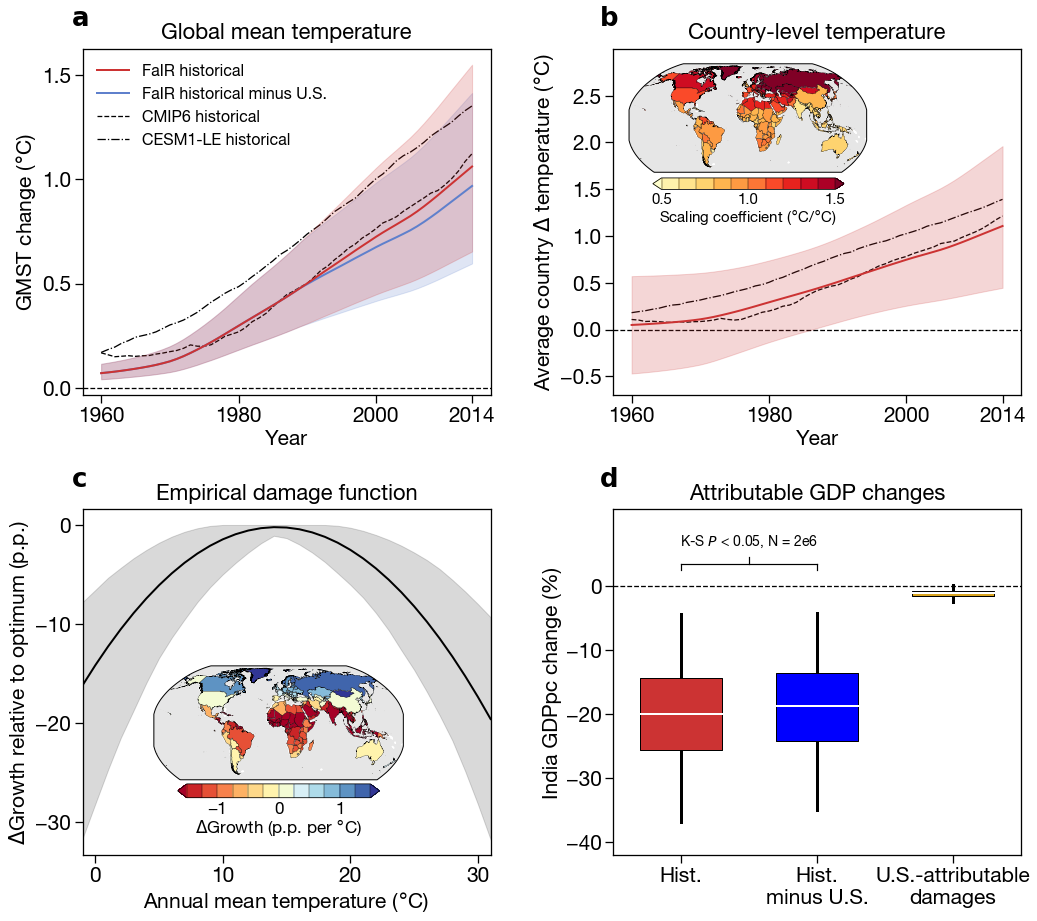

In [22]:
fig = plt.figure(figsize=(16.5,16))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 21.0
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3

tfs = 22

gs2 = gridspec.GridSpec(2,2)
gs2.update(left=0.1,right=0.89,top=0.84,bottom=0.14,wspace=0.3,hspace=0.33)


# FaIR and climate models global mean surface temperature
ax = plt.subplot(gs2[0,0])
plt.setp(ax.spines.values(), linewidth=1.3)

# all countries
plt.plot(years_plot,
        gmst_diff_fair_all_plot.mean(dim="fair_run"),
        color=[0.8,0.2,0.2],linewidth=2,label="FaIR historical",
        zorder=5)
ax.fill_between(years_plot,
               gmst_diff_fair_all_plot.quantile(0.025,dim="fair_run"),
               gmst_diff_fair_all_plot.quantile(0.975,dim="fair_run"),
               color=[0.8,0.2,0.2],alpha=0.2,
               zorder=3)

# minus USA
plt.plot(years_plot,
        gmst_diff_fair_subtract_plot.mean(dim="fair_run"),
        color=[0.373,0.5,0.8],linewidth=2,label="FaIR historical minus U.S.",
        zorder=4)
ax.fill_between(years_plot,
               gmst_diff_fair_subtract_plot.quantile(0.025,dim="fair_run"),
               gmst_diff_fair_subtract_plot.quantile(0.975,dim="fair_run"),
               color=[0.373,0.5,0.8],alpha=0.2,
               zorder=2)

# GCM means
plt.plot(years_plot,gmst_diff.loc["CMIP6",:,:].mean(dim="member"),
        color="black",linewidth=1.3,linestyle="--",label="CMIP6 historical",
        zorder=2)
plt.plot(years_plot,gmst_diff.loc["CESM1-SFLE",:,:].mean(dim="member"),
        color="black",linewidth=1.3,linestyle="-.",label="CESM1-LE historical",
        zorder=2)

plt.axhline(y=0,linewidth=1.3,color="black",linestyle="--")

plt.xticks([1960,1980,2000,2014])
plt.xlabel("Year")
plt.ylabel("GMST change ($\degree$C)")
plt.yticks([0,0.5,1,1.5])
plt.title("Global mean temperature",
         fontsize=tfs,pad=10)
plt.legend(loc="upper left",frameon=False,
          fontsize=16)




ax = plt.subplot(gs2[0,1])
plt.setp(ax.spines.values(), linewidth=1.3)


# FaIR
plt.plot(years_plot,
        tdiff_pred_mean.loc[:,y1_plot:y2_plot].mean(dim="iso"),
        color=[0.8,0.2,0.2],linewidth=2,
        label="FaIR + pattern scaling",zorder=4)
ax.fill_between(years_plot,
               tdiff_pred_pctiles.loc[0.025,:,y1_plot:y2_plot].mean(dim="iso"),
               tdiff_pred_pctiles.loc[0.975,:,y1_plot:y2_plot].mean(dim="iso"),
               color=[0.8,0.2,0.2],alpha=0.2,zorder=3)


# climate models
plt.plot(years_plot,t_diff.loc["CMIP6",:,:,:].mean(dim=["member","iso"]),
        color="black",linewidth=1.3,linestyle="--",label="CMIP6 historical",
        zorder=2)
plt.plot(years_plot,t_diff.loc["CESM1-SFLE",:,:].mean(dim=["member","iso"]),
        color="black",linewidth=1.3,linestyle="-.",label="CESM1-LE historical",
        zorder=2)

plt.ylim([-0.7,3])
plt.yticks([-0.5,0,0.5,1,1.5,2,2.5])
plt.axhline(y=0,color="black",linestyle="--",linewidth=1.3)
plt.xticks([1960,1980,2000,2014])
plt.xlabel("Year")
plt.ylabel("Average country $\Delta$ temperature ($\degree$C)")
plt.title("Country-level temperature",
         fontsize=tfs,pad=10)


# map for scaling coefficients
inset_ax = fig.add_axes([0.56,0.68,0.2,0.2],projection=ccrs.Robinson())
inset_ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
plt.setp(inset_ax.spines.values(), linewidth=0.3)
inset_ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.9,0.9,0.9])
inset_ax.add_feature(cart.feature.LAND, edgecolor="white",facecolor=[0.98,0.98,0.98])

# set colors
vmin = 0.5
vmax = 1.5
ncol = 11
cmapname = 'YlOrRd'

bounds = np.linspace(vmin,vmax,ncol)
cols = plt.get_cmap(cmapname)(np.linspace(0,1,len(bounds)+1))
cm = colors.ListedColormap(cols[1:-1])
cm.set_over(cols[-1])
cm.set_under(cols[0])
norm = colors.Normalize(vmin=vmin,vmax=vmax)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)

# add geoms
add_country_geometries(inset_ax,pattern_coefs_mean,pattern_coefs_mean.iso.values,
                      iso_shp,shp,"ISO3",cbar)

# colorbar
l = 0.58
b = 0.718
w = 0.161
h = 0.01
cbar_ax = fig.add_axes([l,b,w,h])
cb = fig.colorbar(cbar,cax=cbar_ax,orientation="horizontal",
                  drawedges=True,extend="both",
                 ticks=[0.5,1.0,1.5])
cbar_ax.tick_params(direction="in",width=0.05)
cb.set_label("Scaling coefficient ($\degree$C/$\degree$C)",
            fontsize=15,labelpad=0)
cbar_ax.tick_params(labelsize=15)



ax = plt.subplot(gs2[1,0])
plt.setp(ax.spines.values(), linewidth=1.3)

yh_xr = xr.DataArray(np.array(yhat_boot),
                    coords=[np.arange(1,nboot+1,1),temps],
                    dims=["boot","temp"])
yh = yh_xr - yh_xr.max(dim="temp")
yh_mean = yh.mean(dim="boot")
yh_upper = yh.quantile(0.975,dim="boot")
yh_lower = yh.quantile(0.025,dim="boot")

plt.plot(temps,yh_mean*100,linewidth=2,alpha=1,
        color="black",zorder=20)
ax.fill_between(temps,yh_lower*100,yh_upper*100,
               color="black",alpha=0.15)

plt.xlim([-1,31])
plt.ylabel("$\Delta$Growth relative to optimum (p.p.)")
plt.xlabel("Annual mean temperature ($\degree$C)")
plt.yticks([-30,-20,-10,0])
plt.title("Empirical damage function",
         fontsize=tfs,pad=10)


# marginal effects map
inset_ax = fig.add_axes([0.16,0.15,0.21,0.21],projection=ccrs.Robinson())
inset_ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
plt.setp(inset_ax.spines.values(), linewidth=0.5)

inset_ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.9,0.9,0.9])
inset_ax.add_feature(cart.feature.LAND, edgecolor="white",facecolor=[0.98,0.98,0.98])

# set colors
vmin = -1.5
vmax = 1.5
ncol = 13
cmapname = 'RdYlBu'

bounds = np.linspace(vmin,vmax,ncol)
cols = plt.get_cmap(cmapname)(np.linspace(0,1,len(bounds)+1))
cm = colors.ListedColormap(cols[1:-1])
cm.set_over(cols[-1])
cm.set_under(cols[0])
norm = colors.Normalize(vmin=vmin,vmax=vmax)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)

# add geoms
add_country_geometries(inset_ax,margeffects,margeffects.iso.values,
                      iso_shp,shp,"ISO3",cbar)

# colorbar
l = 0.18
b = 0.19
w = 0.17
h = 0.012
cbar_ax = fig.add_axes([l,b,w,h])
cb = fig.colorbar(cbar,cax=cbar_ax,orientation="horizontal",
                  drawedges=True,extend="both",
                 ticks=[-1,0,1])
cbar_ax.tick_params(direction="in",width=0.05)
cb.set_label("$\Delta$Growth (p.p. per $\degree$C)",
            fontsize=17,labelpad=0)
cbar_ax.tick_params(labelsize=17)




ax = plt.subplot(gs2[1,1])
plt.setp(ax.spines.values(), linewidth=1.3)

plt.plot([1,1],[ex_hist_damages_pctiles.loc[0.025],
               ex_hist_damages_pctiles.loc[0.975]],
        linewidth=3,color="black",linestyle="-",zorder=5)
ax.fill_between([0.7,1.3],ex_hist_damages_pctiles.loc[0.25],
               ex_hist_damages_pctiles.loc[0.75],
               facecolor=[0.8,0.2,0.2],alpha=1,zorder=10,linewidth=1,
               edgecolor="black")
plt.plot([0.7,1.3],[ex_hist_damages_pctiles.loc[0.5],
                    ex_hist_damages_pctiles.loc[0.5]],
         color="white",alpha=1,zorder=15,linewidth=2)


plt.plot([2,2],[ex_subtract_damages_pctiles.loc[0.025],
               ex_subtract_damages_pctiles.loc[0.975]],
        linewidth=3,color="black",linestyle="-",zorder=5)
ax.fill_between([1.7,2.3],ex_subtract_damages_pctiles.loc[0.25],
               ex_subtract_damages_pctiles.loc[0.75],
               facecolor="blue",alpha=1,zorder=10,linewidth=1,
               edgecolor="black")
plt.plot([1.7,2.3],[ex_subtract_damages_pctiles.loc[0.5],
                    ex_subtract_damages_pctiles.loc[0.5]],
         color="white",alpha=1,zorder=15,linewidth=2)


plt.plot([3,3],[ex_attr_damages_pctiles.loc[0.025],
               ex_attr_damages_pctiles.loc[0.975]],
        linewidth=3,color="black",linestyle="-",zorder=5)
ax.fill_between([2.7,3.3],ex_attr_damages_pctiles.loc[0.25],
               ex_attr_damages_pctiles.loc[0.75],
               facecolor="goldenrod",alpha=1,zorder=10,linewidth=1,
               edgecolor="black")
plt.plot([2.7,3.3],[ex_attr_damages_pctiles.loc[0.5],
                    ex_attr_damages_pctiles.loc[0.5]],
         color="white",alpha=1,zorder=15,linewidth=2)



plt.axhline(y=0,linewidth=1.3,
            linestyle="--",color="black")
plt.xticks(ticks=[1,2,3],
          labels=["Hist.","Hist."+"\n"+"minus U.S.",
                 "U.S.-attributable"+"\n"+"damages"])
plt.title("Attributable GDP changes",pad=10,fontsize=tfs)
plt.ylabel("India GDPpc change (%)")
plt.xlim([0.5,3.5])
plt.ylim([-42,12])
plt.yticks([-40,-30,-20,-10,0])

plt.plot([1,2],[3.5,3.5],linewidth=1.2,
        color="black",linestyle="-")
plt.plot([1,1],[2.5,3.5],linewidth=1.2,
        color="black",linestyle="-")
plt.plot([2,2],[2.5,3.5],linewidth=1.2,
        color="black",linestyle="-")
plt.plot([1.5,1.5],[3.5,4.5],linewidth=1.2,
        color="black",linestyle="-")

plt.text(0.99,6.3,"K-S $\it{P}$ < 0.05, N = 2e6",fontsize=14)




x1 = 0.09
x2 = 0.535
y1 = 0.86
y2 = 0.46
plt.figtext(x1,y1,r'$\bf{a}$',fontsize=26)
plt.figtext(x2,y1,r'$\bf{b}$',fontsize=26)
plt.figtext(x1,y2,r'$\bf{c}$',fontsize=26)
plt.figtext(x2,y2,r'$\bf{d}$',fontsize=26)

#plt.savefig("../Figures/Publication/New/Fig1.pdf")
plt.savefig("../Figures/Publication/ClimChange_Final/Fig1.pdf")

plt.show()